In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Cargar el archivo 

In [3]:
df = pd.read_excel('Data/Productividad.xlsx')

# Mostrar las primeras filas para entender la estructura
df.head()

,dia_sem,fecha_dia,mes,neg,region,canal,cedula,cargobase,ult_fecha_ingreso,antiguedad,capt_tot
0,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,51000001,AA176,EJECUTIVO COMERCIAL,2024-11-13,3 Meses o menos,0
1,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000044,AA333,EJECUTIVO COMERCIAL,2017-11-10,1 año o más,0
2,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000020,AA067,EJECUTIVO COMERCIAL,2021-12-17,1 año o más,0
3,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000047,AA323,EJECUTIVO COMERCIAL,2021-07-09,1 año o más,0
4,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000019,AA204,EJECUTIVO COMERCIAL,2020-01-16,1 año o más,0


### Preprocesamiento

In [67]:
df['fecha_dia'] = pd.to_datetime(df['fecha_dia'])
df['anio_mes'] = df['fecha_dia'].dt.to_period('M')

### Agrupar productividad por cargo sin aplicar factor costo

In [68]:
productividad_por_cargo = df.groupby('cargobase')['capt_tot'].agg(
    promedio_productividad='mean',
    mediana_productividad='median',
    std_productividad='std',
    cantidad_registros='count',
    empleados_unicos=lambda x: df.loc[x.index, 'cedula'].nunique()
).reset_index()

In [69]:
productividad_por_cargo

,cargobase,promedio_productividad,mediana_productividad,std_productividad,cantidad_registros,empleados_unicos
0,EJECUTIVO COMERCIAL,8.589468,7.0,7.804759,32414,388
1,EJECUTIVO COMERCIAL FIN DE SEMANA,4.285469,0.0,7.598261,1748,26
2,EJECUTIVO COMERCIAL MEDIO TIEMPO,4.616202,4.0,4.308898,753,10


### Calcular productividad ajustada por costo

In [70]:
costos_relativos = {
    'EJECUTIVO COMERCIAL': 1.0,
    'EJECUTIVO COMERCIAL MEDIO TIEMPO': 0.5,
    'EJECUTIVO COMERCIAL FIN DE SEMANA': 0.4
}
productividad_por_cargo['costo_relativo'] = productividad_por_cargo['cargobase'].map(costos_relativos)
productividad_por_cargo['productividad_ajustada'] = (
    productividad_por_cargo['promedio_productividad'] / productividad_por_cargo['costo_relativo']
)


In [72]:
productividad_por_cargo

,cargobase,promedio_productividad,mediana_productividad,std_productividad,cantidad_registros,empleados_unicos,costo_relativo,productividad_ajustada
0,EJECUTIVO COMERCIAL,8.589468,7.0,7.804759,32414,388,1.0,8.589468
1,EJECUTIVO COMERCIAL FIN DE SEMANA,4.285469,0.0,7.598261,1748,26,0.4,10.713673
2,EJECUTIVO COMERCIAL MEDIO TIEMPO,4.616202,4.0,4.308898,753,10,0.5,9.232404


### Captaciones por mes

In [73]:
captaciones_mensuales = df.groupby(['anio_mes','cargobase'])['capt_tot'].mean().reset_index()
captaciones_mensuales['anio_mes'] = captaciones_mensuales['anio_mes'].astype(str)
captaciones_mensuales['costo_relativo'] = captaciones_mensuales['cargobase'].map(costos_relativos)
captaciones_mensuales['productividad_ajustada'] = (
    captaciones_mensuales['capt_tot'] / captaciones_mensuales['costo_relativo']
)
captaciones_mensuales

,anio_mes,cargobase,capt_tot,costo_relativo,productividad_ajustada
0,2025-01,EJECUTIVO COMERCIAL,7.984789,1.0,7.984789
1,2025-01,EJECUTIVO COMERCIAL FIN DE SEMANA,4.623656,0.4,11.559140
2,2025-01,EJECUTIVO COMERCIAL MEDIO TIEMPO,5.075269,0.5,10.150538
3,2025-02,EJECUTIVO COMERCIAL,9.515703,1.0,9.515703
4,2025-02,EJECUTIVO COMERCIAL FIN DE SEMANA,4.539683,0.4,11.349206
5,2025-02,EJECUTIVO COMERCIAL MEDIO TIEMPO,4.992857,0.5,9.985714
6,2025-03,EJECUTIVO COMERCIAL,8.462594,1.0,8.462594
7,2025-03,EJECUTIVO COMERCIAL FIN DE SEMANA,4.459677,0.4,11.149194
8,2025-03,EJECUTIVO COMERCIAL MEDIO TIEMPO,4.497696,0.5,8.995392
9,2025-04,EJECUTIVO COMERCIAL,8.482712,1.0,8.482712


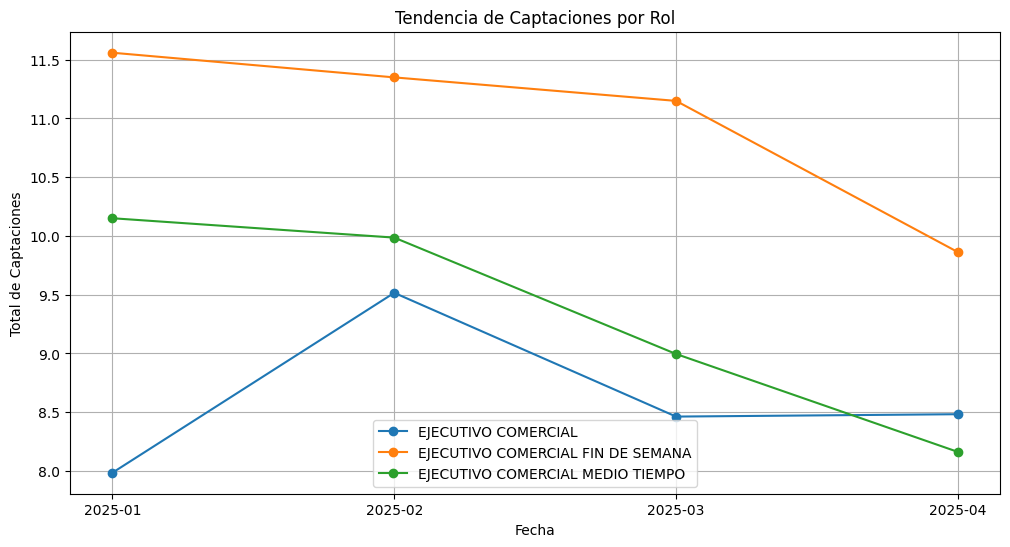

In [74]:
pivot = captaciones_mensuales.pivot(index='anio_mes', columns='cargobase', values='productividad_ajustada').fillna(0)
plt.figure(figsize=(12,6))
for rol in pivot.columns:
    plt.plot(pivot.index, pivot[rol], marker='o', label=rol)
plt.title('Tendencia de Captaciones por Rol')
plt.xlabel('Fecha')
plt.ylabel('Total de Captaciones')
plt.legend()
plt.grid(True)
plt.show()

### Captaciones por cedula

#### Optener cedulas y roles

In [75]:
df_cargos_cedulas = df[['cedula','cargobase']].drop_duplicates()
df_cargos_cedulas

,cedula,cargobase
0,AA176,EJECUTIVO COMERCIAL
1,AA333,EJECUTIVO COMERCIAL
2,AA067,EJECUTIVO COMERCIAL
3,AA323,EJECUTIVO COMERCIAL
4,AA204,EJECUTIVO COMERCIAL
...,...,...
25467,AA066,EJECUTIVO COMERCIAL
25470,AA071,EJECUTIVO COMERCIAL
25474,AA093,EJECUTIVO COMERCIAL
25477,AA330,EJECUTIVO COMERCIAL


In [76]:
captaciones_mensuales = df.groupby(['anio_mes','cedula'])['capt_tot'].mean().reset_index()
captaciones_mensuales['anio_mes'] = captaciones_mensuales['anio_mes'].astype(str)

captaciones_mensuales

,anio_mes,cedula,capt_tot
0,2025-01,AA001,13.193548
1,2025-01,AA002,7.548387
2,2025-01,AA004,13.193548
3,2025-01,AA005,6.806452
4,2025-01,AA007,4.838710
...,...,...,...
1158,2025-04,AA418,4.700000
1159,2025-04,AA419,9.200000
1160,2025-04,AA420,4.866667
1161,2025-04,AA421,2.566667


#### Asignar roles al agrupamiento por cedulas

In [77]:
captaciones_mensuales = pd.merge(
    right=df_cargos_cedulas,
    left=captaciones_mensuales,
    on='cedula',
    how='left'

)
captaciones_mensuales

,anio_mes,cedula,capt_tot,cargobase
0,2025-01,AA001,13.193548,EJECUTIVO COMERCIAL
1,2025-01,AA002,7.548387,EJECUTIVO COMERCIAL
2,2025-01,AA004,13.193548,EJECUTIVO COMERCIAL
3,2025-01,AA005,6.806452,EJECUTIVO COMERCIAL
4,2025-01,AA007,4.838710,EJECUTIVO COMERCIAL
...,...,...,...,...
1160,2025-04,AA418,4.700000,EJECUTIVO COMERCIAL
1161,2025-04,AA419,9.200000,EJECUTIVO COMERCIAL
1162,2025-04,AA420,4.866667,EJECUTIVO COMERCIAL
1163,2025-04,AA421,2.566667,EJECUTIVO COMERCIAL


#### Aplicar formula costo a las captaciones promedio por cedula

In [78]:
captaciones_mensuales['costo_relativo'] = captaciones_mensuales['cargobase'].map(costos_relativos)
captaciones_mensuales['productividad_ajustada'] = (
    captaciones_mensuales['capt_tot'] / captaciones_mensuales['costo_relativo']
)
captaciones_mensuales

,anio_mes,cedula,capt_tot,cargobase,costo_relativo,productividad_ajustada
0,2025-01,AA001,13.193548,EJECUTIVO COMERCIAL,1.0,13.193548
1,2025-01,AA002,7.548387,EJECUTIVO COMERCIAL,1.0,7.548387
2,2025-01,AA004,13.193548,EJECUTIVO COMERCIAL,1.0,13.193548
3,2025-01,AA005,6.806452,EJECUTIVO COMERCIAL,1.0,6.806452
4,2025-01,AA007,4.838710,EJECUTIVO COMERCIAL,1.0,4.838710
...,...,...,...,...,...,...
1160,2025-04,AA418,4.700000,EJECUTIVO COMERCIAL,1.0,4.700000
1161,2025-04,AA419,9.200000,EJECUTIVO COMERCIAL,1.0,9.200000
1162,2025-04,AA420,4.866667,EJECUTIVO COMERCIAL,1.0,4.866667
1163,2025-04,AA421,2.566667,EJECUTIVO COMERCIAL,1.0,2.566667


In [79]:
df_captaciones_mensuales = captaciones_mensuales.copy()

#### Obtener tendencia de crecimiento mes a mes

In [80]:

df_captaciones_mensuales['anio_mes'] = pd.to_datetime(captaciones_mensuales['anio_mes']).dt.to_period('M')


df_captaciones_mensuales = df_captaciones_mensuales.sort_values(['cargobase', 'anio_mes'])


grouped = df_captaciones_mensuales.groupby(['cargobase', 'anio_mes'])['capt_tot'].sum().reset_index()


grouped['tasa_crecimiento'] = grouped.groupby('cargobase')['capt_tot'].pct_change()


grouped['tasa_crecimiento_pct'] = grouped['tasa_crecimiento'] * 100
grouped['tasa_crecimiento_pct'] = grouped['tasa_crecimiento_pct'].round(2)
grouped['anio_mes'] = grouped['anio_mes'].astype(str)
grouped

,cargobase,anio_mes,capt_tot,tasa_crecimiento,tasa_crecimiento_pct
0,EJECUTIVO COMERCIAL,2025-01,1964.258065,NaN,NaN
1,EJECUTIVO COMERCIAL,2025-02,2445.535714,0.245018,24.50
2,EJECUTIVO COMERCIAL,2025-03,2391.612903,-0.022049,-2.20
3,EJECUTIVO COMERCIAL,2025-04,2502.400000,0.046323,4.63
4,EJECUTIVO COMERCIAL FIN DE SEMANA,2025-01,27.741935,NaN,NaN
5,EJECUTIVO COMERCIAL FIN DE SEMANA,2025-02,40.857143,0.472757,47.28
6,EJECUTIVO COMERCIAL FIN DE SEMANA,2025-03,89.193548,1.183059,118.31
7,EJECUTIVO COMERCIAL FIN DE SEMANA,2025-04,90.733333,0.017263,1.73
8,EJECUTIVO COMERCIAL MEDIO TIEMPO,2025-01,30.451613,NaN,NaN
9,EJECUTIVO COMERCIAL MEDIO TIEMPO,2025-02,24.964286,-0.180198,-18.02


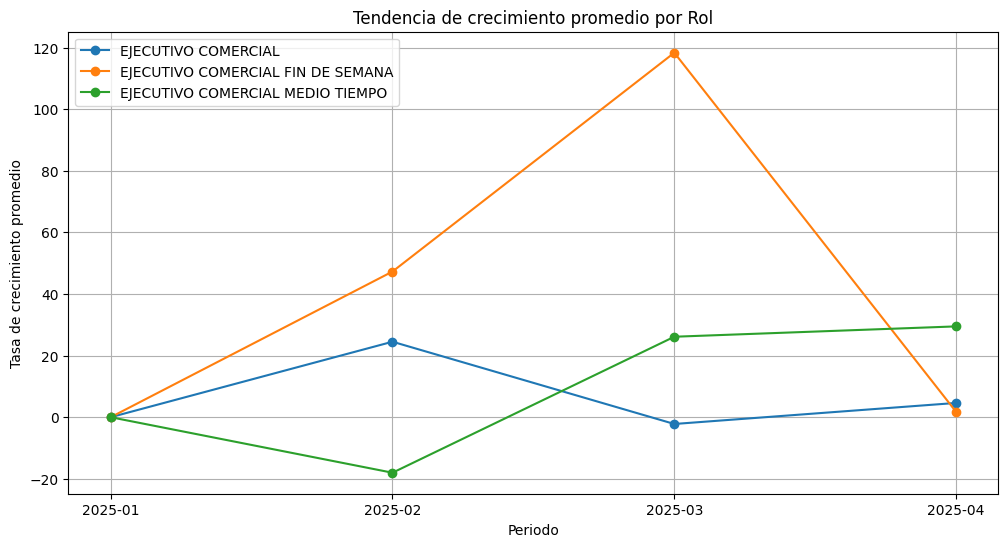

In [81]:
pivot = grouped.pivot(index='anio_mes', columns='cargobase', values='tasa_crecimiento_pct').fillna(0)
plt.figure(figsize=(12,6))
for rol in pivot.columns:
    plt.plot(pivot.index, pivot[rol], marker='o', label=rol)
plt.title('Tendencia de crecimiento promedio por Rol')
plt.xlabel('Periodo')
plt.ylabel('Tasa de crecimiento promedio')
plt.legend()
plt.grid(True)
plt.show()